In [1]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

import random
import math

import multiprocessing
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
from scipy import interpolate

import matplotlib.pyplot as plt

from scipy import interpolate
# We'll use double precision throughout for better numerics.
dtype = np.float64

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels


plt.style.use('ggplot') 
plt.style.use('seaborn-paper')
plt.style.use('seaborn-whitegrid')

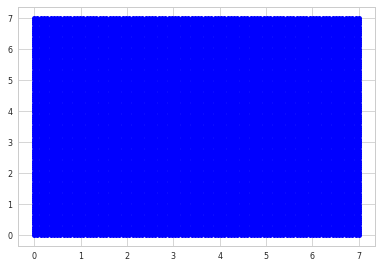

In [2]:
# generate x,y -coordinates
N=100

x= np.linspace(0,7,N)
y = np.linspace(0,7,N)

xx, yy = np.meshgrid(x, y, sparse=False)

plt.plot(xx,yy,'.',markersize=10,color='blue')

plt.show()


In [3]:
x = np.reshape(xx,(N*N))
y = np.reshape(yy,(N*N))

print(np.shape(x))
print(np.shape(y))


X = np.zeros((len(x),2))
X[:,0] = x
X[:,1] = y 

print(np.shape(X))
print(np.shape(X[:,0]))


(10000,)
(10000,)
(10000, 2)
(10000,)


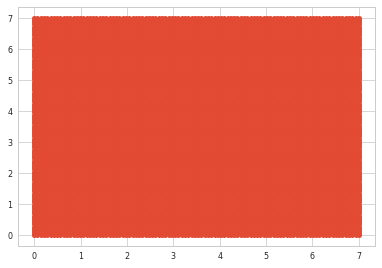

In [4]:
plt.plot(X[:,0],X[:,1],'.',markersize=10)
plt.show()

In [5]:
def non_stat_matern12( X, lengthscales, stddev):
    ''' Non-stationary Matern 12 kernel'''

    Xs = tf.reduce_sum(input_tensor=tf.square(X), axis=-1, keepdims=True)
    Ls = tf.square(lengthscales)
    dist = -2 * tf.matmul(X, X, transpose_b=True)
    dist += Xs + tf.linalg.matrix_transpose(Xs)
    Lscale = Ls + tf.linalg.matrix_transpose(Ls)
    dist = tf.divide(2*dist,Lscale)
    dist = tf.sqrt(tf.maximum(dist, 1e-40))
    prefactL = 2 * tf.matmul(lengthscales, lengthscales, transpose_b=True)
    prefactV = tf.matmul(stddev, stddev, transpose_b=True)

    return tf.multiply(prefactV,tf.multiply( tf.sqrt(tf.maximum(tf.divide(prefactL,Lscale), 1e-40)),tf.exp(-dist)))
    

In [6]:
np.shape(X[:,0])

(10000,)

In [7]:
# generate l,sigma and mean from RBF kernels

obs_error = 0.005

def make_functions():
    
    KK = tfk.ExponentiatedQuadratic(amplitude=1.0,length_scale=np.float64(1.0)).matrix(X,X)#1

    I = 1e-8 * tf.eye(N*N, dtype=tf.float64) #NN
    KK = KK +I 
    LL=tf.linalg.cholesky(KK)

    mvn = tfd.MultivariateNormalLinearOperator(
        loc=tf.zeros_like(np.zeros((1,N*N)),dtype=tf.float64),
        scale=tf.linalg.LinearOperatorLowerTriangular(LL))

    mean_mean = 2.0
    fun_mean_vals = np.squeeze(tf.math.softplus(mean_mean + mvn.sample()).numpy()[0])
    
    func_mean = fun_mean_vals
    #func_mean = interpolate.interp2d(x,y, fun_mean_vals)
    

    KK = tfk.ExponentiatedQuadratic(amplitude=1.0,length_scale=np.float64(1.0)).matrix(X,X)
    I = 1e-8 * tf.eye(N*N, dtype=tf.float64) #NN
    KK = KK +I 
    LL=tf.linalg.cholesky(KK)

    mvn = tfd.MultivariateNormalLinearOperator(
        loc=tf.zeros_like(np.zeros((1,N*N)),dtype=tf.float64),
        scale=tf.linalg.LinearOperatorLowerTriangular(LL))

    meanl = 0
    fun_len_vals = np.squeeze(tf.math.softplus(meanl + mvn.sample()).numpy()[0])
    #func_len = interpolate.interp2d(x,y, fun_len_vals)
    
    func_len = fun_len_vals


    KK = tfk.ExponentiatedQuadratic(amplitude=2.0, length_scale=np.float64(1.0)).matrix(X,X)#or 1.5(I think in the case of 100)

    I = 1e-8 * tf.eye(N*N, dtype=tf.float64) #NN
    KK = KK +I 
    LL=tf.linalg.cholesky(KK)

    mvn = tfd.MultivariateNormalLinearOperator(
        loc=tf.zeros_like(np.zeros((1,N*N)),dtype=tf.float64),
        scale=tf.linalg.LinearOperatorLowerTriangular(LL))

    fun_amp_vals = np.squeeze(tf.math.softplus(mvn.sample()).numpy()[0])

    func_amp = fun_amp_vals # no more interpolation
    
    return func_mean,func_len, func_amp


def make_ts(func_mean,func_len, func_amp):
    
    L = func_len
    sigma = func_amp
    mean = func_mean

    KK=non_stat_matern12(X,L[...,None],sigma[...,None])
    I = obs_error**2 * tf.eye(N*N, dtype=tf.float64) #NN
    KK = KK +I 
            
    jitter=1e-4

    while True:
        try:
            LL=tf.linalg.cholesky(KK)
            break
        except:
            print('adding jitter...')
            I = jitter * tf.eye(N*N, dtype=tf.float64) #NN
            KK = KK +I 
            jitter*=10
    
    mvn = tfd.MultivariateNormalLinearOperator(
        loc=mean[None,...], 
        scale=tf.linalg.LinearOperatorLowerTriangular(LL))
    
    sample = mvn.sample().numpy()[0]

    return sample, mean, L, sigma
        


In [8]:
#collect a lot more data

def make_repeat(repeat):

    n_list = [25]#10,50,100

    func_mean,func_len, func_amp = make_functions()
    
    for n_indv in n_list:
      
        data =[]
        mean_all = []
        L_all =[]
        var_all=[]
        x_all=[]
        y_all=[]

        for i in tqdm(range(n_indv)):
            
            sample, mean, L, sigma = make_ts(func_mean,func_len, func_amp)
            
            # collect the data and all the parameters
            data.append(sample)
            mean_all.append(mean)
            L_all.append(L)
            var_all.append(sigma)
            
            x_all.append(x)
            y_all.append(y)

            
        data= np.array(data).reshape(N*N*n_indv,1)
        
        x_total = np.array(x_all).reshape(N*N*n_indv,1)
        y_total = np.array(y_all).reshape(N*N*n_indv,1)


        mean_total = np.array(mean_all).reshape(N*N*n_indv,1)
        len_total = np.array(L_all).reshape(N*N*n_indv,1)
        var_total = np.array(var_all).reshape(N*N*n_indv,1)
        
        dataset = pd.DataFrame({'x-coordinate':x_total.flatten(),'y-coordinate':y_total.flatten(), 'observations':data.flatten(),'Mean':mean_total.flatten(),'Lengthscale':len_total.flatten(),'Variance':var_total.flatten(),'ID':0})


        # set the IDs according to the batches
        nb = n_indv
        npb = N

        for j in tqdm(range(nb)):
            dataset['ID'].iloc[j*npb:(j+1)*npb]= j

        dataset.to_csv('standard_values_ns_synthetic_2d_data_mean_indv_' + str(n_indv) + '_' + '.csv')

In [ ]:
# simulate TS data for multiple individuals
make_repeat(0)

2022-11-30 09:51:16.146387: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
  0%|          | 0/25 [00:00<?, ?it/s]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


  4%|▍         | 1/25 [01:43<41:33, 103.88s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


  8%|▊         | 2/25 [03:28<40:00, 104.39s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 12%|█▏        | 3/25 [05:12<38:12, 104.18s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 16%|█▌        | 4/25 [06:55<36:14, 103.56s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 20%|██        | 5/25 [08:38<34:26, 103.34s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 24%|██▍       | 6/25 [10:21<32:41, 103.22s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 28%|██▊       | 7/25 [12:05<31:06, 103.70s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 32%|███▏      | 8/25 [13:47<29:14, 103.20s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 36%|███▌      | 9/25 [15:31<27:34, 103.43s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 40%|████      | 10/25 [17:14<25:46, 103.09s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 44%|████▍     | 11/25 [18:55<23:55, 102.53s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 48%|████▊     | 12/25 [20:38<22:13, 102.61s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 52%|█████▏    | 13/25 [22:20<20:31, 102.60s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 56%|█████▌    | 14/25 [24:04<18:51, 102.89s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 60%|██████    | 15/25 [25:47<17:08, 102.83s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 64%|██████▍   | 16/25 [27:29<15:24, 102.76s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 68%|██████▊   | 17/25 [29:11<13:39, 102.38s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 72%|███████▏  | 18/25 [30:54<11:59, 102.76s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 76%|███████▌  | 19/25 [32:35<10:13, 102.27s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
adding jitter...


 80%|████████  | 20/25 [34:17<08:30, 102.06s/it]

adding jitter...
adding jitter...
adding jitter...
adding jitter...
